In [1]:
import sys
sys.path.append('../python')

import numpy as np
import pytest
import needle as ndl
from needle import backend_ndarray as nd
import needle.nn as nn
import needle.optim as optim
from needle import data as ndldata
import needle.init as init
import needle.ops as ops
import time
from needle.prune import model_to_sparse
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(4)

/home/dudayou/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found permutation search CUDA kernels
[ASP][Info] permutation_search_kernels can be imported.


In [2]:
def MLPNet(dim, hidden_dim=100, num_classes=10, device=ndl.cpu_numpy()):
    ### BEGIN YOUR SOLUTION
    mlpNet = nn.Sequential(
        nn.Linear(in_features=dim, out_features=hidden_dim, device=device), 
        nn.ReLU(), 
        nn.Linear(in_features=hidden_dim, out_features=num_classes, device=device))
    return mlpNet

BATCH_SIZE = 128
HIDDEN_DIM = 128

mnist_train_dataset = ndldata.MNISTDataset("../data/train-images-idx3-ubyte.gz",
                                            "../data/train-labels-idx1-ubyte.gz")

mnist_train_dataloader = ndldata.DataLoader(dataset=mnist_train_dataset,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True)

mnist_test_dataset = ndldata.MNISTDataset("../data/t10k-images-idx3-ubyte.gz",
                                               "../data/t10k-labels-idx1-ubyte.gz")

mnist_test_dataloader = ndldata.DataLoader(dataset=mnist_test_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False)

In [3]:
def eval_GPU(model, test_loader):
    model.eval()
    n_sample, correct = 0, 0
    acc_list = []
    for i, batch in tqdm(enumerate(test_loader)):
        x, y = batch[0], batch[1]
        gx = x.cuda()
        gy = y.cuda()
        gx = gx.reshape((gx.shape[0], -1))
        y_hat = model(gx)

        logit = nd.array(np.argmax(y_hat.cached_data.numpy(), axis=1), device = ndl.cuda())
        # print(logit.device)
        # print(y.cached_data.device)
        correct += np.sum((logit == gy.cached_data).numpy().astype('int'))

        n_sample += gx.shape[0]
        acc_list.append(correct / x.shape[0])

    acc = correct/n_sample
    print('acc {}'.format(acc))

In [4]:
gmodel = MLPNet(784, HIDDEN_DIM, device=ndl.cuda())
gmodel_ckpt = ndl.load('../weights/gmodel_5epoch.pkl', device=ndl.cuda())
gmodel.load_state_dict(gmodel_ckpt)

In [5]:
eval_GPU(gmodel, mnist_test_dataloader)

79it [00:00, 1060.46it/s]

acc 0.969


In [11]:
gmodel.parameters()[2].shape

(128, 10)

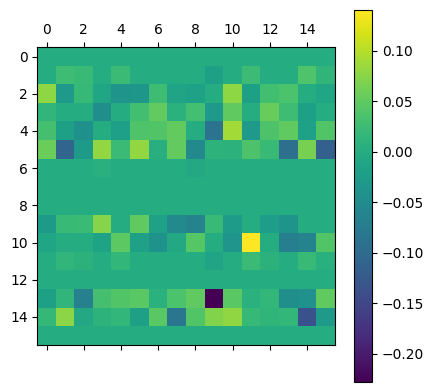

In [16]:
gmodel.parameters()[0]
Linear_1 = gmodel.parameters()[0].numpy()
L_1 = Linear_1[:16, :16]

plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()

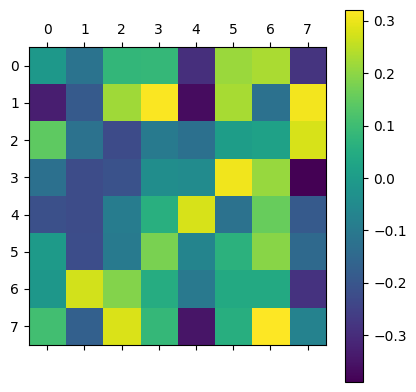

In [12]:
Linear_1 = gmodel.parameters()[2].numpy()
L_1 = Linear_1[:8, :8]

plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()

# Pruning

In [13]:
model_to_sparse(gmodel, device=ndl.cuda())

[ASP] torchvision is imported, can work with the MaskRCNN/KeypointRCNN from torchvision.

[set_permutation_params_from_asp] Set permutation needed parameters

[set_identical_seed] Set the identical seed: 1 for all GPUs to make sure the same results generated in permutation search
[ASP] Sparsifying 0::weight of size=torch.Size([128, 784]) and type=torch.float32 for sparsity
[ASP] Not sparsifying 0::bias of size=torch.Size([128]) and type=torch.float32
[ASP] Auto skipping pruning 2::weight of size=torch.Size([10, 128]) and type=torch.float32 for sparsity
[ASP] Not sparsifying 2::bias of size=torch.Size([10]) and type=torch.float32

[build_offline_permutation_graph] Further refine the model graph built by Torch.FX for offline permutation
[build_fx_graph] The torch version is: 1.13.0+cu116, version major is: 1, version minor is: 13, version minimum is: 0+cu116
[build_fx_graph] The Torch.FX is supported.

[build_fx_graph] Print the model structure with pure PyTorch function
Sequential(
  (0

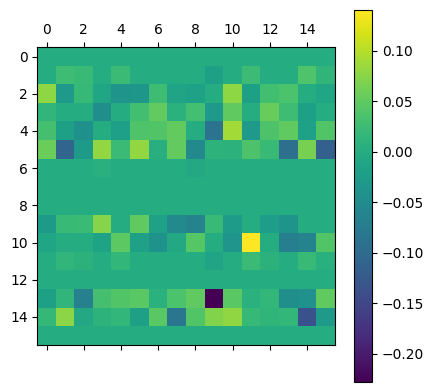

In [14]:
# gmodel.parameters()[0]
Linear_1 = gmodel.parameters()[0].numpy()
L_1 = Linear_1[:16, :16]

plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()

In [5]:
gmodel = MLPNet(784, HIDDEN_DIM, device=ndl.cuda())
eval_GPU(gmodel, mnist_test_dataloader)

79it [00:00, 1074.56it/s]

acc 0.1026
